In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

In [2]:
# Load data

df = pd.read_csv('clv_data.csv')
df.head(3)

,Unnamed: 0,id,age,gender,income,days_on_platform,city,purchases
0,0,0,NaN,Male,126895,14.0,San Francisco,0
1,1,1,NaN,Male,161474,14.0,Tokyo,0
2,2,2,24.0,Male,104723,34.0,London,1


<AxesSubplot:>

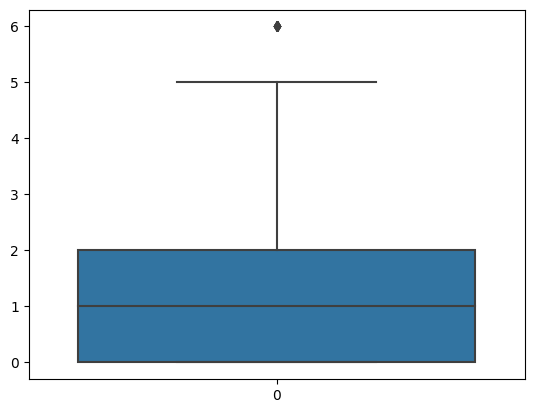

In [3]:
# Detect Outliers - Method 1: Box Plot

sns.boxplot(df['purchases'])

In [4]:
# Extract outliers from Box Plot

def ext_outliers(serie):
    # Get IQR
    q1 = np.quantile(serie, 0.25)
    q3 = np.quantile(serie, 0.75)
    iqr = q3 - q1

    # Upper and lower Whiskers
    upper_w = q3 + 1.5*iqr
    lower_w = q1 - 1.5*iqr

    outliers = serie[(serie <= lower_w) | (serie >= upper_w)]
    print(f'''Number of outliers in the serie is: {len(outliers)}

Outliers from Box Plot are:''')
    return outliers

ext_outliers(df['purchases'])

Number of outliers in the serie is: 59

Outliers from Box Plot are:


47      5
104     5
142     5
301     5
323     5
485     6
486     5
1026    5
1104    6
1112    5
1120    6
1125    5
1374    5
1504    5
1623    5
1669    6
1670    5
1809    6
1818    5
1836    5
1870    5
2180    5
2463    6
2548    5
2572    5
2605    5
2717    5
2901    5
3032    6
3080    5
3105    5
3162    5
3170    5
3291    5
3298    5
3321    5
3361    5
3380    5
3410    5
3566    5
3603    6
3631    6
3835    5
3848    5
4003    6
4141    5
4334    5
4346    5
4545    5
4597    5
4611    5
4620    5
4662    5
4691    5
4728    5
4751    5
4761    5
4895    5
4958    5
Name: purchases, dtype: int64

{'bodies': [<matplotlib.collections.PolyCollection at 0x7fe111771d90>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7fe111789190>,
 'cmins': <matplotlib.collections.LineCollection at 0x7fe1404529a0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7fe140452d60>}

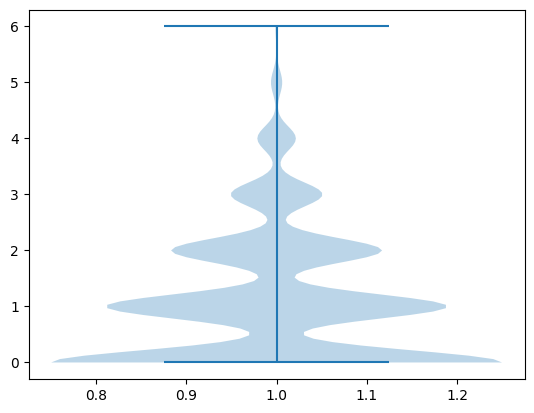

In [5]:
# Detect Outliers - Method 2: Violin Plot
# It works like the Box Plot but shows the density of data points. Thus we can see if there is any outliers or not.
# Can use both plots together

plt.violinplot(df['purchases'])

In [6]:
# Detect Outliers - Method 3: Percentile
# Using percentiles, exclude high and low values

def percentile_outliers(array,
                        lower_bound_perc,
                        upper_bound_perc):
    
    upper_bound = np.percentile(df['purchases'], upper_bound_perc)
    lower_bound = np.percentile(df['purchases'], lower_bound_perc)
    
    outliers = array[(array <= lower_bound) | (array >= upper_bound)]
    
    return outliers

percentile_outliers(df['purchases'],
               upper_bound_perc = 99,
               lower_bound_perc = 1)

0       0
1       0
5       0
6       0
8       0
       ..
4991    0
4994    0
4996    0
4997    0
4999    0
Name: purchases, Length: 2023, dtype: int64

In [7]:
# Detect Outliers - Method 4: Z-Score
# Using Z-Score, exclude high and low values


def z_score_outliers(array,
                     z_score_lower,
                     z_score_upper):

    z_scores = scipy.stats.zscore(array)
    outliers = (z_scores > 1.96) | (z_scores < -1.96)
    
    return array[outliers]

z_score_outliers(df['purchases'],
                     z_score_lower = -1.96,
                     z_score_upper = 1.96)

28      4
47      5
51      4
67      4
74      4
       ..
4880    4
4895    5
4897    4
4944    4
4958    5
Name: purchases, Length: 227, dtype: int64

In [8]:
# Detect Outliers - Method 5: Isolation Forest
# A decision tree to select outliers. It is more complicated.
# Anomaly will be highlighted with -1


from sklearn.ensemble import IsolationForest

features = ['age','income','days_on_platform','purchases']

## We'll do a simple drop null for now
df = df.dropna()

## Create a training-test set
X = df[features]
X_train = X[:4000]
X_test = X[1000:]

## Fit Model
clf = IsolationForest(n_estimators=50, max_samples=100)
clf.fit(X_train)

## Get Scores
df['scores'] = clf.decision_function(X_train)
df['anomaly'] = clf.predict(X)

## Get Anomalies
outliers=df.loc[df['anomaly']==-1]

outliers

,Unnamed: 0,id,age,gender,income,days_on_platform,city,purchases,scores,anomaly
15,15,15,31.0,Female,226249,20.0,Miami,0,-0.052338,-1
17,17,17,27.0,Female,177582,2.0,London,0,-0.041373,-1
18,18,18,10.0,Female,260,32.0,San Francisco,0,-0.050627,-1
23,23,23,10.0,Female,108804,5.0,Tokyo,2,-0.036888,-1
25,25,25,46.0,Female,112992,9.0,London,3,-0.031265,-1
...,...,...,...,...,...,...,...,...,...,...
4958,4958,4958,47.0,Female,79452,4.0,New York City,5,-0.124229,-1
4970,4970,4970,34.0,Female,9850,3.0,New York City,3,-0.026729,-1
4979,4979,4979,50.0,Male,90750,71.0,New York City,1,-0.072951,-1
4984,4984,4984,24.0,Female,225155,8.0,San Francisco,2,-0.070078,-1


In [13]:
# Handling outlieers - Method 1: Percentile Removal

def percentile_removal(df, column, lower_bound_perc, upper_bound_perc):
    
    col_df = df[column]
    
    upper_bound = np.percentile(col_df, upper_bound_perc)
    lower_bound = np.percentile(col_df, lower_bound_perc)

    outliers = (col_df > upper_bound) | (col_df < lower_bound)
    return df[outliers]

percentile_removal(df, 'purchases', lower_bound_perc=1, upper_bound_perc=99)

,Unnamed: 0,id,age,gender,income,days_on_platform,city,purchases,scores,anomaly
485,485,485,21.0,Female,130753,46.0,London,6,-0.129490,-1
1104,1104,1104,25.0,Female,88148,54.0,San Francisco,6,-0.126223,-1
2463,2463,2463,25.0,Male,66759,12.0,New York City,6,-0.067121,-1
3032,3032,3032,47.0,Female,93304,33.0,London,6,-0.133459,-1
3631,3631,3631,43.0,Male,132673,39.0,London,6,-0.154148,-1
4003,4003,4003,30.0,Male,192656,5.0,San Francisco,6,-0.148864,-1


In [15]:
# Handling outlieers - Method 2: Percentile Removal

def z_score_removal(df, column, lower_z_score, upper_z_score):
    
    col_df = df[column]

    z_scores = scipy.stats.zscore(col_df)
    outliers = (z_scores > upper_z_score) | (z_scores < lower_z_score)
    return df[~outliers]

z_score_removal(df, 'purchases', -1.96, 1.96)

,Unnamed: 0,id,age,gender,income,days_on_platform,city,purchases,scores,anomaly
2,2,2,24.0,Male,104723,34.0,London,1,0.054051,1
3,3,3,29.0,Male,43791,28.0,London,2,0.041778,1
4,4,4,18.0,Female,132181,26.0,London,2,0.012217,1
5,5,5,23.0,Male,12315,14.0,New York City,0,0.035455,1
8,8,8,46.0,Male,129157,23.0,New York City,0,0.031404,1
...,...,...,...,...,...,...,...,...,...,...
4986,4986,4986,23.0,Male,75425,6.0,London,1,0.046970,1
4989,4989,4989,47.0,Female,84987,30.0,Tokyo,0,0.037825,1
4990,4990,4990,33.0,Male,3020,89.0,New York City,0,-0.109234,-1
4991,4991,4991,36.0,Female,26173,34.0,Tokyo,0,0.053786,1


In [16]:
# Handling outlieers - Method 2: Winsorize

def winsorize(df, column, upper, lower):
    col_df = df[column]
    
    perc_upper = np.percentile(df[column],upper)
    perc_lower = np.percentile(df[column],lower)
    
    df[column] = np.where(df[column] >= perc_upper, 
                          perc_upper, 
                          df[column])
    
    df[column] = np.where(df[column] <= perc_lower, 
                          perc_lower, 
                          df[column])
    
    return df

winsorize(df, 'purchases', 97.5, 0.025)

,Unnamed: 0,id,age,gender,income,days_on_platform,city,purchases,scores,anomaly
2,2,2,24.0,Male,104723,34.0,London,1.0,0.054051,1
3,3,3,29.0,Male,43791,28.0,London,2.0,0.041778,1
4,4,4,18.0,Female,132181,26.0,London,2.0,0.012217,1
5,5,5,23.0,Male,12315,14.0,New York City,0.0,0.035455,1
8,8,8,46.0,Male,129157,23.0,New York City,0.0,0.031404,1
...,...,...,...,...,...,...,...,...,...,...
4986,4986,4986,23.0,Male,75425,6.0,London,1.0,0.046970,1
4989,4989,4989,47.0,Female,84987,30.0,Tokyo,0.0,0.037825,1
4990,4990,4990,33.0,Male,3020,89.0,New York City,0.0,-0.109234,-1
4991,4991,4991,36.0,Female,26173,34.0,Tokyo,0.0,0.053786,1
